In [9]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew, kurtosis, norm, t


NASDAQ-100 (^NDX)
- Observations: 9,937
- Mean daily return: 0.065236 (0.0652%)
- Variance: 2.675076
- Standard deviation: 1.63557 (1.64%)
- Minimum return: -15.08%
- Maximum return: 18.77%
- Median return: 0.12%
- Skewness: 0.0608
- Kurtosis: 7.8702

KOSPI (^KOSPI)
- Observations: 10,308
- Mean daily return: 0.039585 (0.0396%)
- Variance: 2.260262
- Standard deviation: 1.50342 (1.50%)
- Minimum return: -12.02%
- Maximum return: 11.95%
- Median return: 0.05%
- Skewness: -0.0179
- Kurtosis: 5.5521



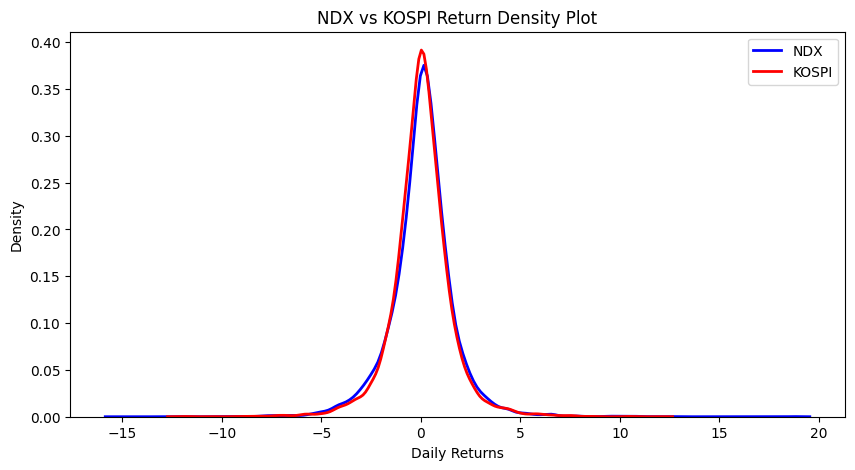

In [10]:
# Load the datasets
kospi_data = pd.read_csv("^kospi_d.csv", parse_dates=["Date"], index_col="Date")
ndx_data = pd.read_csv("^ndx_d.csv", parse_dates=["Date"], index_col="Date")

# Align datasets to start on the same date
common_start_date = max(ndx_data.index.min(), kospi_data.index.min())
ndx_data = ndx_data.loc[common_start_date:]
kospi_data = kospi_data.loc[common_start_date:]

# Compute daily simple returns
ndx_data["Return"] = 100 * ndx_data["Close"].pct_change()
kospi_data["Return"] = 100 * kospi_data["Close"].pct_change()

# Drop NA values
ndx_data.dropna(inplace=True)
kospi_data.dropna(inplace=True)

# Compute statistics
def compute_stats(data):
    return {
        "Observations": len(data["Return"]),
        "Mean Return": (data["Return"].mean(), data["Return"].mean()),
        "Variance": data["Return"].var(),
        "Standard Deviation": (data["Return"].std(), data["Return"].std()),
        "Minimum Return": data["Return"].min(),
        "Maximum Return": data["Return"].max(),
        "Median Return": data["Return"].median(),
        "Skewness": skew(data["Return"]),
        "Kurtosis": kurtosis(data["Return"]),
    }

ndx_stats = compute_stats(ndx_data)
kospi_stats = compute_stats(kospi_data)

# Print results
print(f"""
NASDAQ-100 (^NDX)
- Observations: {ndx_stats["Observations"]:,}
- Mean daily return: {ndx_stats["Mean Return"][0]:.6f} ({ndx_stats["Mean Return"][1]:.4f}%)
- Variance: {ndx_stats["Variance"]:.6f}
- Standard deviation: {ndx_stats["Standard Deviation"][0]:.5f} ({ndx_stats["Standard Deviation"][1]:.2f}%)
- Minimum return: {ndx_stats["Minimum Return"]:.2f}%
- Maximum return: {ndx_stats["Maximum Return"]:.2f}%
- Median return: {ndx_stats["Median Return"]:.2f}%
- Skewness: {ndx_stats["Skewness"]:.4f}
- Kurtosis: {ndx_stats["Kurtosis"]:.4f}

KOSPI (^KOSPI)
- Observations: {kospi_stats["Observations"]:,}
- Mean daily return: {kospi_stats["Mean Return"][0]:.6f} ({kospi_stats["Mean Return"][1]:.4f}%)
- Variance: {kospi_stats["Variance"]:.6f}
- Standard deviation: {kospi_stats["Standard Deviation"][0]:.5f} ({kospi_stats["Standard Deviation"][1]:.2f}%)
- Minimum return: {kospi_stats["Minimum Return"]:.2f}%
- Maximum return: {kospi_stats["Maximum Return"]:.2f}%
- Median return: {kospi_stats["Median Return"]:.2f}%
- Skewness: {kospi_stats["Skewness"]:.4f}
- Kurtosis: {kospi_stats["Kurtosis"]:.4f}
""")

# Create a single density plot for both indices
plt.figure(figsize=(10, 5))

# Density plot for NDX
sns.kdeplot(ndx_data["Return"], color="blue", label="NDX", linewidth=2)

# Density plot for KOSPI
sns.kdeplot(kospi_data["Return"], color="red", label="KOSPI", linewidth=2)

# Labels and title
plt.title("NDX vs KOSPI Return Density Plot")
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend()

# Show plot
plt.show()

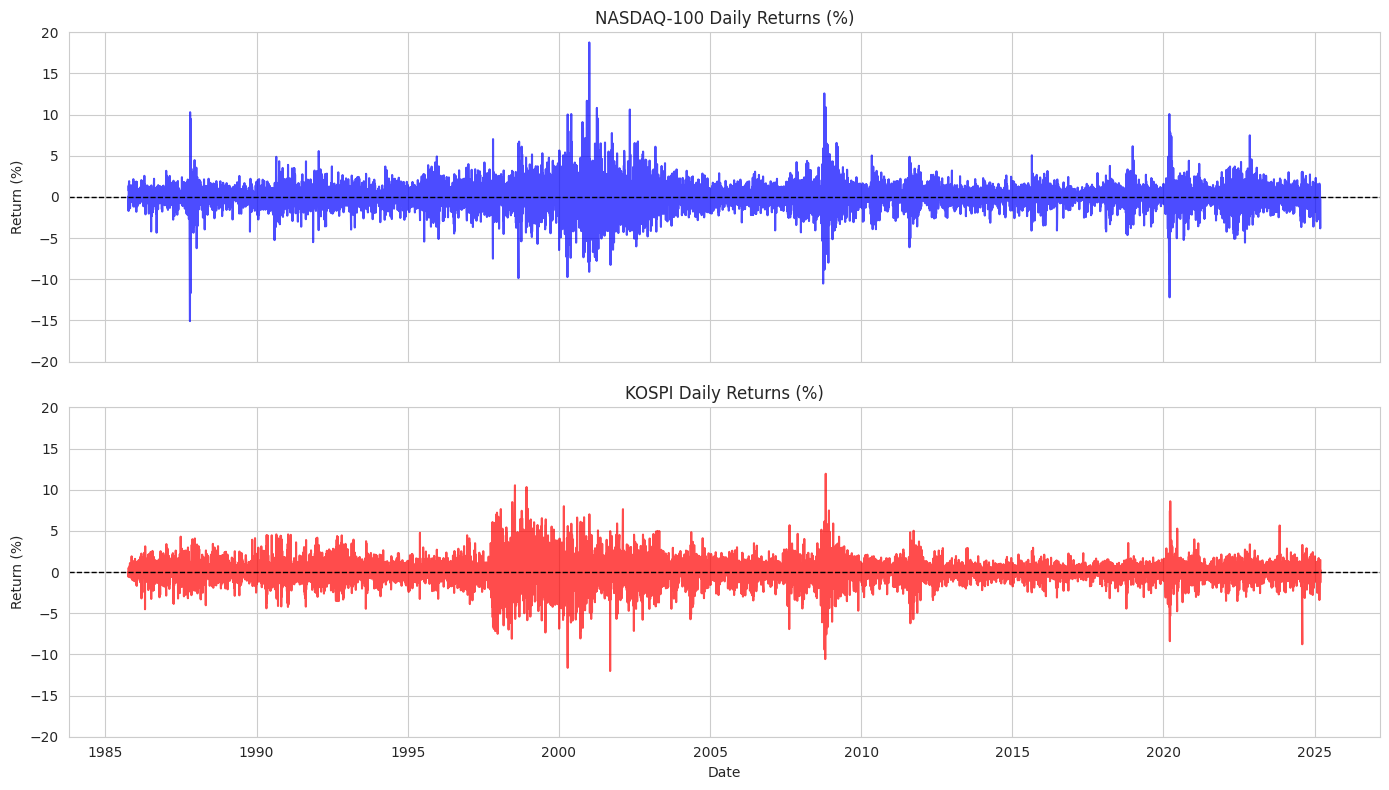

In [11]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot daily returns for NDX
axes[0].plot(ndx_data.index, ndx_data["Return"], color="blue", alpha=0.7)
axes[0].set_title("NASDAQ-100 Daily Returns (%)")
axes[0].set_ylabel("Return (%)")
axes[0].set_ylim(-20, 20)
axes[0].axhline(0, linestyle="--", color="black", linewidth=1)

# Plot daily returns for KOSPI
axes[1].plot(kospi_data.index, kospi_data["Return"], color="red", alpha=0.7)
axes[1].set_title("KOSPI Daily Returns (%)")
axes[1].set_ylabel("Return (%)")
axes[1].set_ylim(-20, 20)
axes[1].axhline(0, linestyle="--", color="black", linewidth=1)

# Improve spacing
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [ ]:
# Compute daily returns and scale by 100
ndx_data["Return"] = ((ndx_data["Close"] / ndx_data["Close"].shift(1)) - 1) * 100
kospi_data["Return"] = ((kospi_data["Close"] / kospi_data["Close"].shift(1)) - 1) * 100

# Drop NA values
ndx_data.dropna(inplace=True)
kospi_data.dropna(inplace=True)

# Set parameters
var_levels = [0.01, 0.05, 0.10]  # 1%, 5%, 10% VaR levels
update_freq = 1  # Update model daily (use 21 if updating monthly)

# Function to compute FHS VaR with a true 10-year rolling window
def filtered_historical_simulation(data, update_freq, var_levels):
    start_date = data.index.min() + pd.DateOffset(years=10)  # Define when forecasts can start
    dates = data.loc[start_date:].index  # Forecasting starts after the initial 10-year window
    var_results = {alpha: [] for alpha in var_levels}

    for date in dates[::update_freq]:  # Update at chosen frequency
        train_start = date - pd.DateOffset(years=10)  # Get the start of the 10-year window
        train_data = data.loc[train_start:date]  # Select exact 10-year rolling window

        # Fit GARCH(1,1)
        garch_model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Constant')
        garch_fit = garch_model.fit(disp="off")

        # Compute standardized residuals
        residuals = garch_fit.std_resid
    
        # Forecast next period's volatility
        forecasts = garch_fit.forecast(start=date, reindex=False)
        forecast_vol = np.sqrt(forecasts.variance.iloc[-1].mean())  # Extract sigma_t+1
        
        # Compute rolling mean return
        rolling_mean = garch_fit.params['mu']

        # Compute VaR for each confidence level
        for alpha in var_levels:
            residual_quantile = residuals.quantile(alpha)  # Get quantile from residuals
            var_value = - rolling_mean - forecast_vol * residual_quantile  # Compute VaR
            var_results[alpha].append((date, var_value))  # Store results

    return var_results

# Compute VaR forecasts for NDX and KOSPI using a true 10-year window
ndx_var = filtered_historical_simulation(ndx_data["Return"], update_freq, var_levels)
kospi_var = filtered_historical_simulation(kospi_data["Return"], update_freq, var_levels)

# Convert results to DataFrame (as positive %VaR)
ndx_var_df = pd.DataFrame({f"VaR {int((1 - alpha) * 100)}%": [v[1] for v in ndx_var[alpha]] for alpha in var_levels},
                           index=[v[0] for v in ndx_var[var_levels[0]]])
kospi_var_df = pd.DataFrame({f"VaR {int((1 - alpha) * 100)}%": [v[1] for v in kospi_var[alpha]] for alpha in var_levels},
                             index=[v[0] for v in kospi_var[var_levels[0]]])

# Plot VaR estimates
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# NDX VaR
ndx_var_df.plot(ax=axes[0], title="Filtered Historical Simulation VaR for NDX")
axes[0].set_ylabel("VaR (%)")

# KOSPI VaR
kospi_var_df.plot(ax=axes[1], title="Filtered Historical Simulation VaR for KOSPI")
axes[1].set_ylabel("VaR (%)")

plt.xlabel("Date")
plt.show()

KeyError: 'CLOSE'

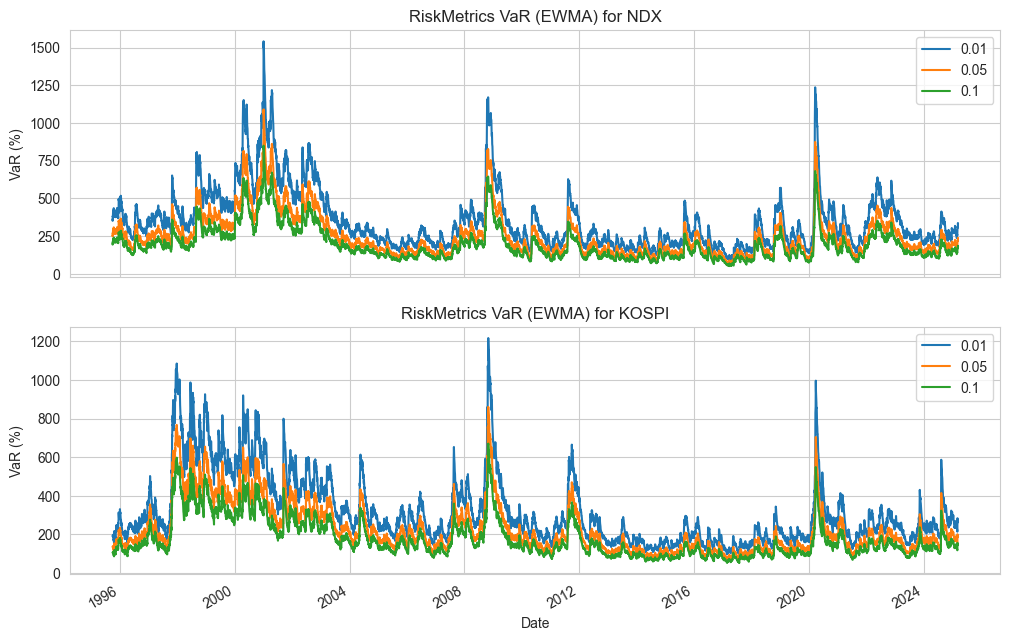

In [ ]:
# Set decay factor for EWMA (RiskMetrics)
lambda_ewma = 0.94  # Daily data

# Function to compute RiskMetrics VaR using explicit summation
def riskmetrics_var_explicit(data, lambda_ewma, var_levels):
    ewma_var = np.zeros(len(data))  # Store variance estimates
    
    # Compute EWMA variance using explicit summation
    for t in range(len(data)):
        past_returns = data.iloc[:t+1]  # Take all past data up to time t
        weights = (1 - lambda_ewma) * lambda_ewma ** np.arange(len(past_returns))[::-1]  # Compute correct decay weights
        ewma_var[t] = np.sum(weights * past_returns**2)  # Apply formula

    ewma_vol = np.sqrt(ewma_var)  # Convert variance to standard deviation

    # Compute VaR for different confidence levels using normal quantiles
    var_results = {alpha: -ewma_vol * stats.norm.ppf(alpha) * 100 for alpha in var_levels}  # % VaR

    return pd.DataFrame(var_results, index=data.index)

# Compute RiskMetrics VaR for NDX and KOSPI using explicit summation
ndx_var_riskmetrics_explicit = riskmetrics_var_explicit(ndx_data["Return"].dropna(), lambda_ewma, [0.01, 0.05, 0.10])
kospi_var_riskmetrics_explicit = riskmetrics_var_explicit(kospi_data["Return"].dropna(), lambda_ewma, [0.01, 0.05, 0.10])

# Find the first date where VaR is available for NDX
first_ndx_var_date = ndx_var_df.index.min()

# Find the first date where VaR is available for KOSPI
first_kospi_var_date = kospi_var_df.index.min()

# Trim RiskMetrics VaR data to start from the same date as FHS VaR
ndx_var_riskmetrics_explicit = ndx_var_riskmetrics_explicit.loc[first_ndx_var_date:]
kospi_var_riskmetrics_explicit = kospi_var_riskmetrics_explicit.loc[first_kospi_var_date:]

# Plot RiskMetrics VaR
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# NDX VaR
ndx_var_riskmetrics_explicit.plot(ax=axes[0], title="RiskMetrics VaR (EWMA) for NDX")
axes[0].set_ylabel("VaR (%)")

# KOSPI VaR
kospi_var_riskmetrics_explicit.plot(ax=axes[1], title="RiskMetrics VaR (EWMA) for KOSPI")
axes[1].set_ylabel("VaR (%)")

plt.xlabel("Date")
plt.show()




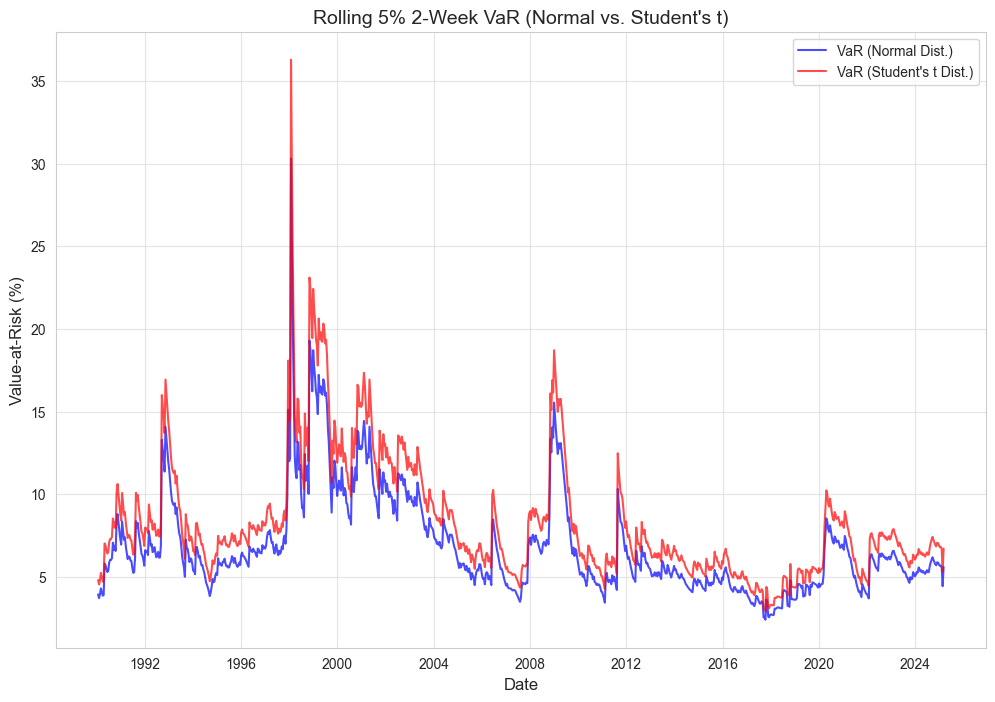

In [ ]:
kospi = pd.read_csv("^kospi.csv", parse_dates=["DATE"], index_col="DATE")
ndx = pd.read_csv("^ndx.csv")

kospi = kospi.sort_index()

# Resample to get Thursday closing prices (weekly)
thursday_prices = kospi.resample("W-THU").last()

# Select every second Thursday to get non-overlapping 2-week returns
non_overlapping_thursdays = thursday_prices.iloc[::2]

# Compute non-overlapping returns
returns = ((non_overlapping_thursdays["CLOSE"] / non_overlapping_thursdays["CLOSE"].shift(1)) - 1) * 100
returns = returns.dropna()  # Remove any NaN values that result from the shift

# get first 10 years
start_date = returns.index.min()  # Get the first available date
end_date = start_date + pd.DateOffset(years=10)  # Add 10 years to the start date

# Filter the returns to get the first 10 years
first_10_years_returns = returns[(returns.index >= start_date) & (returns.index < end_date)]

# 5. Fit a GARCH(1,1) model to the initial sample with a constant mean
garch_model = arch_model(first_10_years_returns, vol='Garch', p=1, q=1, mean='Constant')
garch_fit = garch_model.fit(disp="off")

# 6. Calculate the 5% 2-week VaR using the GARCH model
# Forecast the volatility for the next 2-week period
forecast_horizon = 1  # 1-step ahead forecast for the next 2 weeks (since returns are biweekly)
forecast = garch_fit.forecast(horizon=forecast_horizon)

# Extract the volatility forecast for the 2-week horizon
volatility_forecast = forecast.variance.values ** 0.5  # square root for volatility

estimated_mean = garch_fit.params['mu']

# Calculate the 5% VaR for the 2-week horizon using the normal distribution
confidence_level = 0.05

# SHOULD WE ASSUME e is NORMAL?

z_score = norm.ppf(confidence_level)  # Get the z-score for the 5% level
VaR_5_percent_norm = -estimated_mean -z_score * volatility_forecast  # The VaR is negative because it represents a loss

# assume e follows t-dist
params = stats.t.fit(first_10_years_returns)


# Extract the degrees of freedom (df) from the fitted parameters
degrees_of_freedom = params[0]

t_quantile = t.ppf(confidence_level, df=degrees_of_freedom)

VaR_5_percent_t = -estimated_mean - t_quantile * volatility_forecast

# 8. Update model: Rolling window
window_size = len(first_10_years_returns)  # Rolling window size

# Initialize an empty list to store VaR values
var_5_percent_norm_list = []
var_5_percent_t_list = []

# Loop through rolling windows
for i in range(len(returns) - window_size):
    rolling_sample = returns.iloc[i : i + window_size]  # Get the rolling window sample

    # Fit a GARCH(1,1) model to the rolling sample
    garch_model = arch_model(rolling_sample, vol='Garch', p=1, q=1, mean='Constant')
    garch_fit = garch_model.fit(disp="off")  # Suppress output

    # Forecast the volatility for the next 2-week period
    forecast = garch_fit.forecast(horizon=1)
    volatility_forecast = np.sqrt(forecast.variance.iloc[-1].mean())  # Extract latest forecasted volatility

    # Estimated mean return
    estimated_mean = garch_fit.params['mu']

    # Compute VaR
    VaR_5_p_norm = -estimated_mean - z_score * volatility_forecast  
    VaR_5_p_t = -estimated_mean - t_quantile * volatility_forecast
    var_5_percent_norm_list.append(VaR_5_p_norm)
    var_5_percent_t_list.append(VaR_5_p_t)

# Convert the VaR list to a DataFrame with timestamps
var_norm_series = pd.Series(var_5_percent_norm_list, index=returns.index[window_size:])
var_t_series = pd.Series(var_5_percent_t_list, index=returns.index[window_size:])

# Plot the two VaR series
plt.figure(figsize=(12, 8))
plt.plot(var_norm_series, label="VaR (Normal Dist.)", linestyle="-", color="blue", alpha=0.7)
plt.plot(var_t_series, label="VaR (Student's t Dist.)", linestyle="-", color="red", alpha=0.7)

# Add titles and labels
plt.title("Rolling 5% 2-Week VaR (Normal vs. Student's t)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value-at-Risk (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="-", alpha=0.5)

# Show the plot
plt.show()

<Figure size 1200x800 with 0 Axes>

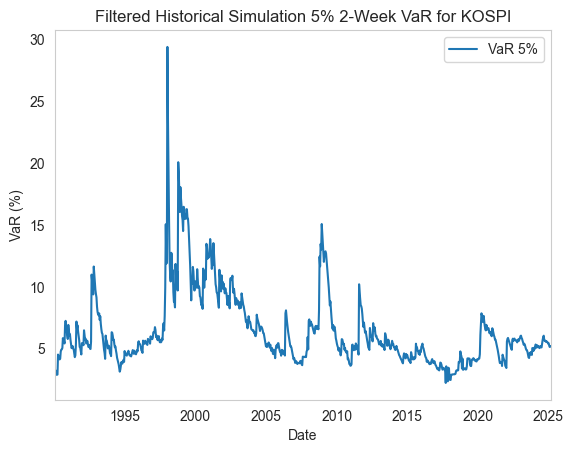

In [ ]:
# Load dataset
kospi_data = pd.read_csv("^kospi.csv", parse_dates=["DATE"], index_col="DATE")
kospi_data = kospi_data.sort_index()

# Resample to get Thursday closing prices (biweekly)
thursday_prices = kospi_data.resample("W-THU").last()

# Select every second Thursday for non-overlapping 2-week returns
biweekly_prices = thursday_prices.iloc[::2]

# Compute non-overlapping 2-week returns and scale by 100
biweekly_returns = ((biweekly_prices["CLOSE"] / biweekly_prices["CLOSE"].shift(1)) - 1) * 100
biweekly_returns.dropna(inplace=True)

# Set parameters
var_level = 0.05  # 5% VaR
update_freq = 1  # Update model at each available 2-week period

# Function to compute 5% 2-week VaR with a rolling 10-year window
def filtered_historical_simulation(data, update_freq, var_level):
    start_date = data.index.min() + pd.DateOffset(years=10)  # Define when forecasts start
    dates = data.loc[start_date:].index  # Forecasting starts after 10-year window
    var_results = []

    for date in dates[::update_freq]:  # Update at chosen frequency
        train_start = date - pd.DateOffset(years=10)  # Get start of rolling window
        train_data = data.loc[train_start:date]  # Select 10-year window

        # Fit GARCH(1,1)
        garch_model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Constant')
        garch_fit = garch_model.fit(disp="off")

        # Compute standardized residuals
        residuals = garch_fit.std_resid

        # Forecast next period's volatility (2-week ahead)
        forecasts = garch_fit.forecast(start=date, reindex=False)
        forecast_vol = np.sqrt(forecasts.variance.iloc[-1].mean())  # Extract sigma_t+1

        # Compute rolling mean return
        rolling_mean = garch_fit.params['mu']
        residual_quantile = residuals.quantile(var_level) 

        # Compute 5% 2-week VaR
        var_value = - rolling_mean - forecast_vol * residual_quantile  # Compute VaR
        var_results.append((date, var_value))  # Store results

    return var_results

# Compute 5% 2-week VaR forecasts for KOSPI
kospi_var = filtered_historical_simulation(biweekly_returns, update_freq, var_level)

# Convert results to DataFrame (as positive %VaR)
kospi_var_df = pd.DataFrame({"VaR 5%": [v[1] for v in kospi_var]}, index=[v[0] for v in kospi_var])

# Plot 5% 2-week VaR estimates
plt.figure(figsize=(12, 8))
kospi_var_df.plot(title="Filtered Historical Simulation 5% 2-Week VaR for KOSPI", legend=True)
plt.ylabel("VaR (%)")
plt.xlabel("Date")
plt.grid()
plt.show()


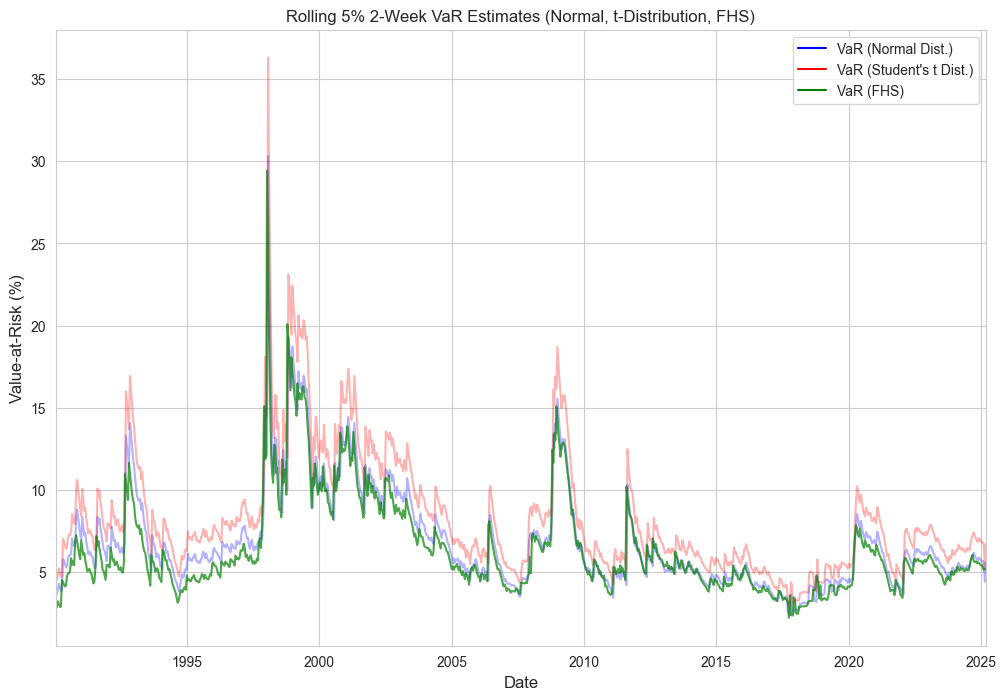

In [ ]:
# Use combined_df.plot() for a quick plot
ax = combined_df.plot(
    figsize=(12, 8),
    grid=True,
    title="Rolling 5% 2-Week VaR Estimates (Normal, t-Distribution, FHS)",
    style=["b-", "r-", "g-"]  # blue for Normal, red for t, green for FHS
)

# Set axis labels
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Value-at-Risk (%)", fontsize=12)

# If you want different transparency (alpha) for each series,
# you can adjust them individually:
for line, alpha in zip(ax.lines, [0.3, 0.3, 0.7]):
    line.set_alpha(alpha)

plt.show()